In [10]:
from gql import gql, Client

import psycopg2
import pandas as pd


import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import json
from tqdm import tqdm

## DATA

In [11]:
# Establish a connection to the database
conn = psycopg2.connect(
    dbname="bali5",
    user="v5",
    password="cqYk1jDQuz9_CuycbBc4_XT.7e4k5FUc",
    host="pg.squid.subsquid.io",
    port="5432"
)

In [12]:
# Create a cursor from the connection
cur = conn.cursor()

# Query the columns of a specific table
cur.execute("""
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_name = 'era_staker'
""")

# Fetch all rows from the cursor
columns = cur.fetchall()

# Print the columns
for column in columns:
    print(column)

('total_reward', 'numeric')
('total_slash', 'numeric')
('commission', 'integer')
('self_bonded', 'numeric')
('total_bonded', 'numeric')
('era_id', 'character varying')
('staker_id', 'character varying')
('role', 'character varying')
('id', 'character varying')


In [ ]:
# Initialize an empty list to hold DataFrames
dfs = []

# Define a function that executes the query for a given range of eras
def fetch_data(start_era, end_era):
    cur.execute(f"""
    WITH validator_rewards AS (
        SELECT
            id,
            era_id,
            CASE
                WHEN total_bonded != 0 THEN total_reward/total_bonded
                ELSE 0
            END AS reward_percentage
        FROM era_staker
        WHERE era_id::integer BETWEEN {start_era} AND {end_era}
    )
    SELECT
        era_nomination.era_id,
        era_nomination.validator_id,
        COUNT(era_nomination.nominator_id) AS num_nominators,
        validator_rewards.reward_percentage
    FROM era_nomination
    INNER JOIN validator_rewards ON era_nomination.validator_id = validator_rewards.id AND era_nomination.era_id = validator_rewards.era_id
    WHERE era_nomination.era_id::integer BETWEEN {start_era} AND {end_era}
    GROUP BY era_nomination.era_id, era_nomination.validator_id, validator_rewards.reward_percentage
    ORDER BY num_nominators DESC
    """)

    # Fetch the data
    data = cur.fetchall()

    # Convert the data to a DataFrame and return it
    return pd.DataFrame(data, columns=['era_id', 'validator_id', 'num_nominators', 'reward_percentage'])

# Fetch data in chunks and append each DataFrame to the list
for era in range(1, 354, 50):
    dfs.append(fetch_data(era, era+49))

# Concatenate all DataFrames in the list into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Ensure data is sorted appropriately
df = df.sort_values(['era_id', 'num_nominators'], ascending=[True, False])

In [14]:
df = pd.read_pickle('reward_percentage_with_amount.pkl')

In [ ]:
import os
import seaborn as sns
import imageio
import matplotlib.pyplot as plt

# Calculate max values for axes
max_reward_percentage = df['reward_percentage'].max()
max_num_nominators = df['num_nominators'].max()

# Calculate min values for axes
min_reward_percentage = max_reward_percentage / -100
min_num_nominators = max_num_nominators / -100

# Create a directory to store the images
if not os.path.exists('images'):
    os.makedirs('images')

# Generate a scatter plot for each era
for era in df['era_id'].unique():
    # Filter the dataframe for the current era
    era_df = df[df['era_id'] == era]

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=era_df, x='reward_percentage', y='num_nominators')
    plt.xlabel('Reward Percentage')
    plt.ylabel('Number of Nominators')
    plt.title(f'Effect of Reward Percentage on Validator Choice in Era {era}')

    # Fix the axes
    plt.xlim(min_reward_percentage, max_reward_percentage)
    plt.ylim(min_num_nominators, max_num_nominators)

    # Save the plot as an image
    plt.savefig(f'images/era_{era}.png')
    plt.close()

# Generate GIF from the images
images = []
for era in df['era_id'].unique():
    images.append(imageio.imread(f'images/era_{era}.png'))

imageio.mimsave('reward_vs_nominators.gif', images, fps=2)


In [9]:
# Initialize an empty list to hold DataFrames
dfs = []

# Define a function that executes the query for a given range of eras
def fetch_data(start_era, end_era):
    cur.execute(f"""
WITH validator_rewards AS (
    SELECT
        id,
        era_id,
        CASE
            WHEN total_bonded != 0 THEN total_reward/total_bonded
            ELSE 0
        END AS reward_per_stake
    FROM era_staker
    WHERE era_id::integer BETWEEN {start_era} AND {end_era}
), nominator_stake AS (
    SELECT
        nominator_id,
        validator_id,
        era_id,
        SUM(stake) as nominator_stake
    FROM nomination
    WHERE era_id::integer BETWEEN {start_era} AND {end_era}
    GROUP BY nominator_id, validator_id, era_id
)
SELECT
    nominator_stake.nominator_id,
    nominator_stake.validator_id,
    nominator_stake.era_id,
    nominator_stake.nominator_stake * validator_rewards.reward_per_stake AS nominator_reward
FROM nominator_stake
INNER JOIN validator_rewards ON nominator_stake.validator_id = validator_rewards.validator_id AND nominator_stake.era_id = validator_rewards.era_id
ORDER BY nominator_reward DESC

    """)

    # Fetch the data
    data = cur.fetchall()

    # Convert the data to a DataFrame and return it
    return pd.DataFrame(data, columns=['era_id', 'validator_id', 'num_nominators', 'reward_percentage'])

# Fetch data in chunks and append each DataFrame to the list
for era in range(1, 354, 50):
    dfs.append(fetch_data(era, era+49))

# Concatenate all DataFrames in the list into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Ensure data is sorted appropriately
df = df.sort_values(['era_id', 'num_nominators'], ascending=[True, False])

NameError: name 'cur' is not defined

In [16]:
import os
import seaborn as sns
import imageio
import matplotlib.pyplot as plt

# Create a copy of the DataFrame and sort it
sorted_df = df.sort_values(['nominator_id', 'validator_id', 'era_id'])

# Create a new column 'previous_era' with the era of the previous nomination for each nominator and validator
sorted_df['previous_era'] = sorted_df.groupby(['nominator_id', 'validator_id'])['era_id'].shift()

# Create a column to identify new nominators or those returning after an absence of 10 eras
sorted_df['new_nominator'] = ((sorted_df['era_id'] - sorted_df['previous_era']) >= 10) | sorted_df['nominator_id'].ne(sorted_df['nominator_id'].shift())

# Create an aggregated dataframe to get the total number of new nominators for each validator in each era
agg_df = sorted_df.groupby(['era_id', 'validator_id', 'reward_percentage']).agg(
    num_nominators=('nominator_id', 'count'),
    new_nominators=('new_nominator', 'sum')
).reset_index()

# Calculate max and min values for axes
max_reward_percentage = agg_df['reward_percentage'].max()
max_num_nominators = agg_df['num_nominators'].max()
min_reward_percentage = max_reward_percentage / -100
min_num_nominators = max_num_nominators / -100

# Create a directory to store the images
if not os.path.exists('images'):
    os.makedirs('images')

# Loop over each era to create the plots
for era in agg_df['era_id'].unique():
    era_df = agg_df[agg_df['era_id'] == era]

    # Create a scatter plot with different colors for new/returning nominators
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=era_df, x='reward_percentage', y='num_nominators', size='new_nominators', hue='new_nominators', palette='viridis')
    plt.xlabel('Reward Percentage')
    plt.ylabel('Number of Nominators')
    plt.title(f'Effect of Reward Percentage on Validator Choice in Era {era}')
    plt.xlim(min_reward_percentage, max_reward_percentage)
    plt.ylim(min_num_nominators, max_num_nominators)
    plt.savefig(f'images/era_{era}.png')
    plt.close()

# Create the GIF as before
images = [imageio.imread(f'images/era_{era}.png') for era in agg_df['era_id'].unique()]
imageio.mimsave('reward_vs_nominators.gif', images, fps=2)


KeyboardInterrupt: 

## NEW

In [3]:
from tqdm import tqdm

In [4]:
# Establish a connection to the database
conn = psycopg2.connect(
    dbname="bali5",
    user="v5",
    password="cqYk1jDQuz9_CuycbBc4_XT.7e4k5FUc",
    host="pg.squid.subsquid.io",
    port="5432"
)
# Create a cursor from the connection
cur = conn.cursor()

In [50]:
try:
    conn.rollback()  # This will roll back the transaction
except:
    pass

In [4]:
# # Create a cursor from the connection
# cur = conn.cursor()
#
#
# # Initialize an empty list to hold DataFrames
# dfs = []
#
# # Define a function that executes the query for a given range of eras
# def fetch_data(start_era, end_era):
#     cur.execute(f"""
#
#
# WITH validator_rewards AS (
#     SELECT
#         id as validator_id,
#         era_id,
#         CASE
#             WHEN total_bonded != 0 THEN total_reward/total_bonded
#             ELSE 0
#         END AS reward_per_stake
#     FROM era_staker
#     WHERE era_id::integer BETWEEN {start_era} AND {end_era}
#     AND role = 'Validator' -- this line filters out only validator records
# ), nominator_stake AS (
#     SELECT
#         nominator_id,
#         validator_id,
#         era_id,
#         SUM(vote) as nominator_stake
#     FROM era_nomination
#     WHERE era_id::integer BETWEEN {start_era} AND {end_era}
#     GROUP BY nominator_id, validator_id, era_id
# ), nominator_rewards AS (
#     SELECT
#         nominator_stake.nominator_id,
#         nominator_stake.validator_id,
#         nominator_stake.era_id,
#         nominator_stake.nominator_stake * validator_rewards.reward_per_stake AS nominator_reward
#     FROM nominator_stake
#     INNER JOIN validator_rewards ON nominator_stake.validator_id = validator_rewards.validator_id AND nominator_stake.era_id = validator_rewards.era_id
# ), nominator_validator_shifts AS (
#     SELECT
#         curr.nominator_id,
#         curr.validator_id AS curr_validator,
#         prev.validator_id AS prev_validator,
#         curr.era_id::integer AS curr_era,
#         prev.era_id::integer AS prev_era,
#         curr.nominator_reward AS curr_reward,
#         prev.nominator_reward AS prev_reward
#     FROM nominator_rewards curr
#     JOIN nominator_rewards prev ON curr.nominator_id = prev.nominator_id AND curr.era_id::integer = prev.era_id::integer + 1
# )
# SELECT * FROM nominator_validator_shifts
# WHERE curr_validator != prev_validator
# ORDER BY nominator_id, curr_era;

#
#
#
#     """)
#
#     # Fetch the data
#     data = cur.fetchall()
#
#     # Convert the data to a DataFrame and return it
#     return pd.DataFrame(data, columns=['nominator_id', 'curr_validator', 'prev_validator', 'curr_era', 'prev_era', 'curr_reward', 'prev_reward'])
#
#
# # Fetch data in chunks and append each DataFrame to the list
# for era in (1, 100, 10):
#     dfs.append(fetch_data(era, era+9))
#
# # Concatenate all DataFrames in the list into a single DataFrame
# df = pd.concat(dfs, ignore_index=True)
#
# # Ensure data is sorted appropriately
# df = df.sort_values(['era_id', 'nominator_id'], ascending=[True, True])

In [58]:
cur.close()
conn.close()

In [180]:
# Establish a connection to the database
conn = psycopg2.connect(
    dbname="bali5",
    user="v5",
    password="cqYk1jDQuz9_CuycbBc4_XT.7e4k5FUc",
    host="pg.squid.subsquid.io",
    port="5432"
)
# Create a cursor from the connection
cur = conn.cursor()

# Initialize an empty list to hold DataFrames
dfs = []

# Define a function that executes the query for a given range of eras
def fetch_data(start_era, end_era):
    cur.execute(f"""



SELECT
    r.era,
    r.validator_id,
    es.self_bonded AS validator_bonded,
    es.total_bonded,
    SUM(r.amount) AS validator_reward  -- Assuming the 'amount' in reward table is the validator's reward
FROM
    era_staker es
JOIN
    reward r ON es.era_id = CAST(r.era AS character varying) AND es.staker_id = r.validator_id
WHERE
    es.role = 'Validator'
    AND es.era_id::integer >=  {start_era}  AND es.era_id::integer <= {end_era}
GROUP BY
    r.era,
    r.validator_id,
    es.self_bonded,
    es.total_bonded;
    """)

    # Fetch the data
    data = cur.fetchall()

    # Convert the data to a DataFrame and return it
    return pd.DataFrame(data, columns=['era', 'validator_id', 'validator_bonded', 'total_bonded', 'validator_reward'])

# Define era ranges
era_ranges = [(start, start+9) for start in range(1, 355, 10)]

# Fetch data in chunks and append each DataFrame to the list
for start, end in tqdm(era_ranges):
    dfs.append(fetch_data(start, end))

# Concatenate all DataFrames in the list into a single DataFrame
df_validators = pd.concat(dfs, ignore_index=True)

# Ensure data is sorted appropriately
df_validators = df_validators.sort_values(['era', 'validator_id'], ascending=[True, True])

100%|██████████| 36/36 [11:11<00:00, 18.65s/it]


In [181]:
# df_validators.to_pickle('df_validators.pkl')

In [3]:
# Establish a connection to the database
conn = psycopg2.connect(
    dbname="bali5",
    user="v5",
    password="cqYk1jDQuz9_CuycbBc4_XT.7e4k5FUc",
    host="pg.squid.subsquid.io",
    port="5432"
)
# Create a cursor from the connection
cur = conn.cursor()

# Initialize an empty list to hold DataFrames
dfs = []

# Define a function that executes the query for a given range of eras
def fetch_data(start_era, end_era):
    cur.execute(f"""

SELECT
    r.era,
    r.staker_id AS nominator_id,  -- Assuming that staker_id is the nominator_id when role is 'Nominator'
    r.validator_id,
    es.self_bonded AS nominator_bonded,
    SUM(r.amount) AS nominator_reward  -- Assuming the 'amount' in reward table is the nominator's reward
FROM
    era_staker es
JOIN
    reward r ON es.era_id = CAST(r.era AS character varying) AND es.staker_id = r.staker_id
WHERE
    es.role = 'Nominator'
    AND es.era_id::integer >=  {start_era}  AND es.era_id::integer <= {end_era}
GROUP BY
    r.era,
    r.staker_id,
    r.validator_id,
    es.self_bonded;


    """)

    # Fetch the data
    data = cur.fetchall()

    # Convert the data to a DataFrame and return it
    return pd.DataFrame(data, columns=['era',  'nominator_id',  'validator_id', 'nominator_bonded',  'nominator_reward'])

# Define era ranges
era_ranges = [(start, start+1) for start in range(154, 355, 1)]


# Fetch data in chunks and append each DataFrame to the list
for start, end in tqdm(era_ranges):
    dfs.append(fetch_data(start, end))

# Concatenate all DataFrames in the list into a single DataFrame
df_nominators = pd.concat(dfs, ignore_index=True)

# Ensure data is sorted appropriately
df_nominators = df_nominators.sort_values(['era',  'nominator_id',], ascending=[True, True])

100%|██████████| 201/201 [1:35:32<00:00, 28.52s/it]


In [6]:
# Concatenate all DataFrames in the list into a single DataFrame
df_nominators = pd.concat(dfs, ignore_index=True)

# Ensure data is sorted appropriately
df_nominators = df_nominators.sort_values(['era',  'nominator_id',], ascending=[True, True])

In [4]:
# df_nominators.to_pickle('df_nominators.pkl')

In [17]:
test_nominators = pd.read_pickle('df_nominators.pkl')

In [18]:
df_validators = pd.read_pickle('df_validators.pkl')

In [19]:
nominators_data = pd.read_pickle('nominator_data_full.pkl')
nominators_data.drop(columns = ['id'], inplace=True)


KeyboardInterrupt



In [ ]:
nominators_data.rename(columns={'selfBonded': 'validatorBonded',
                                'amount': 'nominatorBonded'}, inplace=True)

In [ ]:
nominators_data

In [ ]:
# Subsetting the DataFrame
df_nominators = nominators_data[['era_id', 'nominatorId', 'validatorId', 'nominatorsCount', 'nominatorBonded', 'totalBonded']]

df_validators = nominators_data[['era_id', 'validatorId', 'nominatorsCount', 'validatorBonded', 'totalBonded']]

# Group by era_id and validatorId and then calculate the mean
# df_validators_grouped = df_validators.groupby(['era_id', 'validatorId']).mean().reset_index()
df_validators_grouped = df_validators.groupby(['era_id', 'validatorId']).last().reset_index()

In [25]:
import pandas as pd
import psycopg2

# Database connection parameters (replace with your values)
db_params = {
    'dbname': 'postgres',
    # 'user': 'your_username',
    # 'password': 'your_password',
    'host': 'localhost',
    'port': '5432'
}

# Establish the connection
conn = psycopg2.connect(**db_params)

# SQL query to get rewards for nominators
nominator_rewards_sql = """
SELECT
    era AS era_id,
    account_id AS nominatorId,
    amount AS nominatorReward
FROM public.staking_reward
WHERE validator_id != account_id;
"""

# SQL query to get rewards for validators
validator_rewards_sql = """
SELECT
    era AS era_id,
    account_id AS validatorId,
    amount AS validatorReward
FROM public.staking_reward
WHERE validator_id = account_id;
"""

# Execute the queries and store the results in pandas DataFrames
df_nominator_rewards = pd.read_sql(nominator_rewards_sql, conn)
df_validator_rewards = pd.read_sql(validator_rewards_sql, conn)

# Close the database connection
conn.close()
import pandas as pd
from typing import Union
from substrateinterface import SubstrateInterface



substrate = SubstrateInterface(url="wss://rpc.polkadot.io")

def encode_to_ss58(palic_id: Union[str, bytes], ss58_format: int = None) -> str:
    return substrate.ss58_encode(public_key=palic_id, ss58_format=ss58_format)


df_nominator_rewards['ss58_address'] = df_nominator_rewards['nominatorid'].apply(encode_to_ss58)
df_validator_rewards['ss58_address'] = df_validator_rewards['validatorid'].apply(encode_to_ss58)


df_nominator_rewards.drop(columns = ['nominatorid'], inplace=True)
df_validator_rewards.drop(columns = ['validatorid'], inplace=True)

# Rename the column in df_rewards to match df_
df_nominator_rewards = df_nominator_rewards.rename(columns={'ss58_address': 'nominatorId', 'nominatorreward': 'nominatorReward'})
df_validator_rewards = df_validator_rewards.rename(columns={'ss58_address': 'validatorId', 'validatorreward': 'validatorReward'})


/var/folders/wf/5crfrw2n2bj95k071nfq9hcw0000gn/T/ipykernel_1746/1356135929.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_nominator_rewards = pd.read_sql(nominator_rewards_sql, conn)
/var/folders/wf/5crfrw2n2bj95k071nfq9hcw0000gn/T/ipykernel_1746/1356135929.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_validator_rewards = pd.read_sql(validator_rewards_sql, conn)


In [48]:
# Now, merge the two DataFrames
df_nominators_join = pd.merge(df_nominators,
                         df_nominator_rewards,
                         on=['era_id', 'nominatorId'],
                         how='left')

In [49]:
# Merge rewards into df_validators_grouped
df_validators_join = pd.merge(df_validators_grouped,
                                 df_validator_rewards,
                                 on=['era_id', 'validatorId'],
                                 how='left')

In [ ]:
# # Group by era and validator to calculate total reward
# total_rewards = df_nominators.groupby(['era_id', 'validatorId'])['nominatorReward'].sum().reset_index()
#
# # Merge total rewards with df_validators_grouped
# df_validators_grouped = pd.merge(df_validators_grouped,
#                                  total_rewards.rename(columns={'nominatorReward': 'totalRewardForValidator'}),
#                                  on=['era_id', 'validatorId'],
#                                  how='left')
#
# # Check if 'totalRewardForValidator' exists in df_validators_grouped, if not, initialize it
# if 'totalRewardForValidator' not in df_validators_grouped.columns:
#     df_validators_grouped['totalRewardForValidator'] = 0
#
# # Add validator's own reward to get the final total reward
# df_validators_grouped['totalRewardForValidator'] += df_validators_grouped['validatorReward'].fillna(0)

## DATA

In [2]:
# df_nominators_join.to_pickle('df_nominators_last.pkl')
# df_validators_join.to_pickle('df_validators_last.pkl')

In [2]:
import pandas as pd

In [21]:
df_nominators_join= pd.read_pickle('df_nominators.pkl')
df_validators_join= pd.read_pickle('df_validators.pkl')

In [23]:
df_validators_join

,era,validator_id,validator_bonded,total_bonded,validator_reward
0,1,11uMPbeaEDJhUxzU4ZfWW9VQEsryP9XqFcNRfPdYda6aFWJ,10000000000000,68462876664988174,10387940879832
1,1,121gZtuuG6sq3BZp1UKg8oRLRZvp89SAYSxXypwDJjaSRJR5,4431000000000000,68462921774700542,9105631940997
2,1,12C9U6zSSoZ6pgwR2ksFyBLgQH6v7dkqqPCRyHceoP8MJRo2,10000000000,81850510000000000,10108794889890
3,1,14QBQABMSFBsT3pDTaEQdshq7ZLmhzKiae2weZH45pw5ErYu,10000000000000,68462006802619211,10185961316447
4,1,15MUBwP6dyVw5CXF9PjSSv7SdXQuDSwjX86v1kBodCSWVR7c,600000000000000,68561274891279469,8256801972094
...,...,...,...,...,...
24388,354,1zugcakrhr3ZR7q7B8WKuaZY5BjZAU43m79xEyhNQwLTFjb,100000000000,22182620889623550,7640654179739
24389,354,1zugcapKRuHy2C1PceJxTvXWiq6FHEDm2xa5XSU7KYP3rJE,100000000000,22185708772071604,9459856389257
24390,354,1zugcarJnZ4ft2PiJoGg6DgmZjnKNBrcKTFrAzhGPCX6bJ5,100000000000,22185210382323081,10004066992485
24391,354,1zugcavYA9yCuYwiEYeMHNJm9gXznYjNfXQjZsZukF1Mpow,100000000000,22187777955892790,10186601132039


In [3]:
df_nominators_join= pd.read_pickle('df_nominators_last.pkl')
df_validators_join= pd.read_pickle('df_validators_last.pkl')

In [24]:
df_nominators = df_nominators_join.rename(columns={'era_id': 'era',
                                                   'nominatorId': 'nominator_id',
                                                   'validatorId': 'validator_id',
                                                   'nominatorBonded': 'nominator_bonded',
                                                   'totalBonded': 'total_bonded',
                                                   'nominatorReward': 'nominator_reward',
                                                   })
df_validators = df_validators_join.rename(columns={'era_id': 'era',
                                                   'validatorId': 'validator_id',
                                                   'validatorBonded': 'validator_bonded',
                                                   'totalBonded': 'total_bonded',
                                                   'validatorReward': 'validator_reward',
                                                   })

In [24]:
window_size = 1

# For Nominators
df_nominators['rolling_nominator_bonded'] = df_nominators['nominator_bonded'].rolling(window=window_size).mean()
df_nominators['rolling_nominator_reward'] = df_nominators['nominator_reward'].rolling(window=window_size).mean()

# For Validators
df_validators['rolling_validator_bonded'] = df_validators['validator_bonded'].rolling(window=window_size).mean()
df_validators['rolling_validator_reward'] = df_validators['validator_reward'].rolling(window=window_size).mean()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Calculate reward as a percentage of the bonded amount
df_nominators['rolling_nominator_reward_percentage'] = (df_nominators['rolling_nominator_reward'] / df_nominators['rolling_nominator_bonded']) * 100
df_validators['rolling_validator_reward_percentage'] = (df_validators['rolling_validator_reward'] / df_validators['rolling_validator_bonded']) * 100

plt.figure(figsize=(14, 7))

# Plotting the reward percentages for Nominators and Validators
plt.plot(df_nominators['era'], abs(np.log(abs(df_nominators['rolling_nominator_reward_percentage'])))/2, label='Nominator Rolling Reward Percentage', color='blue')
plt.plot(df_validators['era'],  abs(np.log(abs(df_validators['rolling_validator_reward_percentage'])/200000))/4, label='Validator Rolling Reward Percentage', color='red')

plt.title("Reward as a Percentage of Bonded Amount (Rolling Window) for Nominators and Validators")
plt.xlabel("Era")
plt.ylabel("Reward Percentage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

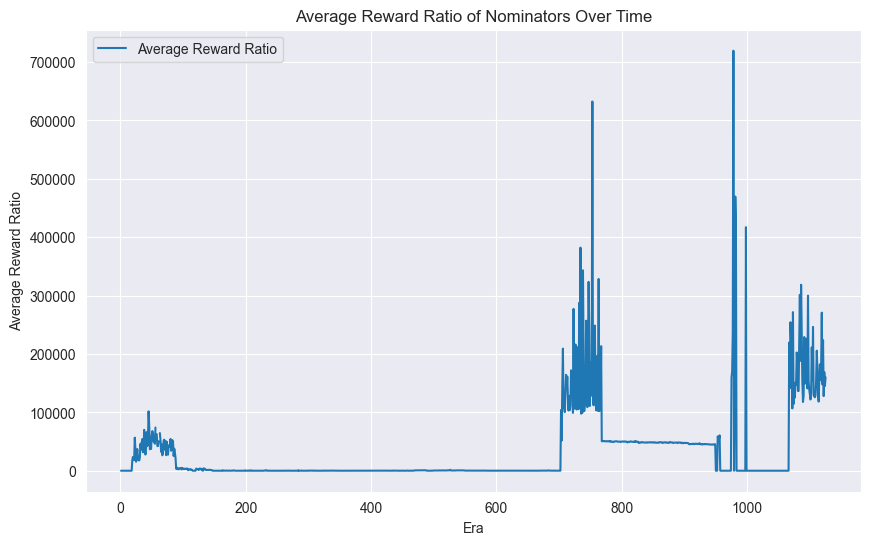

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plotting the rolling metrics for Nominators
plt.plot(df_nominators['era'], df_nominators['rolling_nominator_bonded'], label='Nominator Rolling Bonded Avg', color='blue')
plt.plot(df_nominators['era'], df_nominators['rolling_nominator_reward'], label='Nominator Rolling Reward Avg', color='cyan')

# Plotting the rolling metrics for Validators
plt.plot(df_validators['era'], df_validators['rolling_validator_bonded'], label='Validator Rolling Bonded Avg', color='red')
plt.plot(df_validators['era'], df_validators['rolling_validator_reward'], label='Validator Rolling Reward Avg', color='magenta')

plt.title("Rolling Window Metrics for Nominators and Validators")
plt.xlabel("Era")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'rolling_nominator_bonded'

<Figure size 1400x700 with 0 Axes>

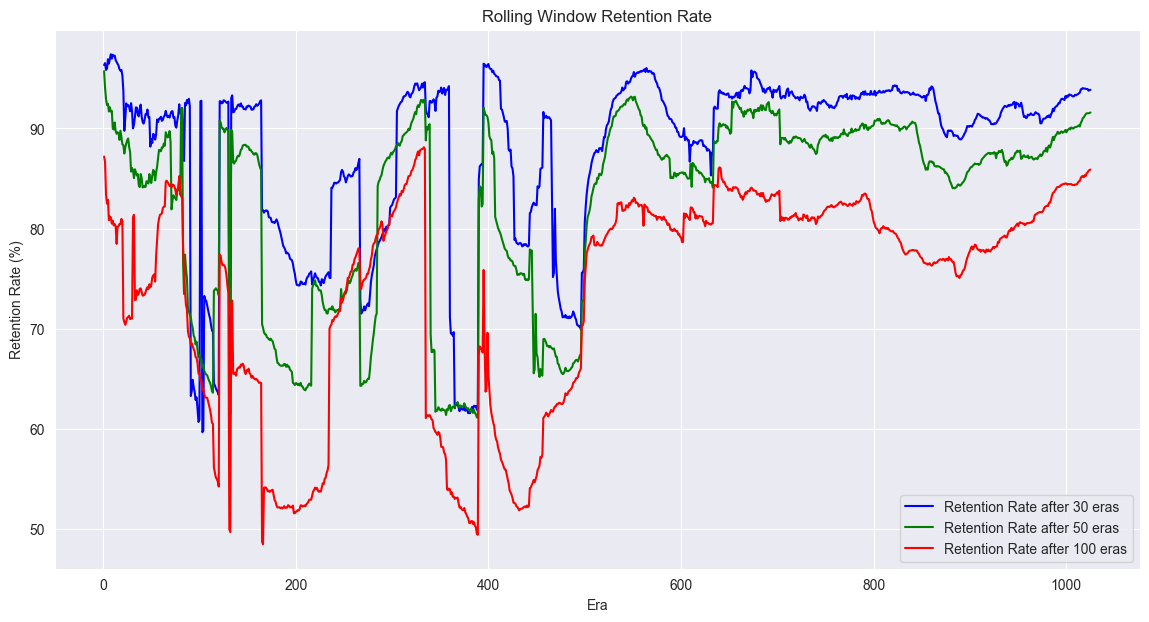

In [7]:
def compute_retention_rate(df, start_era, after_eras):
    """
    Compute retention rate given a start era and a list of eras after the start.
    Returns a list of retention rates corresponding to the eras provided in 'after_eras'.
    """
    # Identify nominators who were bonded in the start era
    initial_nominators = set(df[df['era'] == start_era]['nominator_id'].unique())
    if not initial_nominators:
        return [None] * len(after_eras)

    retention_rates = []
    for after_era in after_eras:
        after_nominators = set(df[df['era'] == start_era + after_era]['nominator_id'].unique())
        retained_nominators = initial_nominators.intersection(after_nominators)
        retention_rate = len(retained_nominators) / len(initial_nominators) * 100
        retention_rates.append(retention_rate)

    return retention_rates

all_eras = df_nominators['era'].unique()
rolling_retention_30 = []
rolling_retention_50 = []
rolling_retention_100 = []

for era in all_eras[:-100]:  # We omit the last 100 eras as we want to compute retention up to 100 eras after each era
    retention_30, retention_50, retention_100 = compute_retention_rate(df_nominators, era, [30, 50, 100])
    rolling_retention_30.append(retention_30)
    rolling_retention_50.append(retention_50)
    rolling_retention_100.append(retention_100)

# Now, let's plot the retention rates:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(all_eras[:-100], rolling_retention_30, label="Retention Rate after 30 eras", color="blue")
plt.plot(all_eras[:-100], rolling_retention_50, label="Retention Rate after 50 eras", color="green")
plt.plot(all_eras[:-100], rolling_retention_100, label="Retention Rate after 100 eras", color="red")

plt.xlabel("Era")
plt.ylabel("Retention Rate (%)")
plt.title("Rolling Window Retention Rate")
plt.legend()
plt.grid(True)
plt.show()

In [27]:

# Merge the dataframes on era and validator_id
df = pd.merge(df_nominators, df_validators,  how='left', left_on=['era','validator_id'], right_on = ['era','validator_id'])

# Create a new dataframe by grouping by era and validator_id and summing nominator_reward
grouped_nominator_reward = df.groupby(['era', 'validator_id'])['nominator_reward'].sum().reset_index()
grouped_nominator_reward = grouped_nominator_reward.rename(columns={"nominator_reward": "sum_nominator_reward"})

# Merge this new dataframe back to your original dataframe
df = pd.merge(df, grouped_nominator_reward,  how='left', left_on=['era', 'validator_id'], right_on = ['era', 'validator_id'])

# Calculate total_reward_current as sum of sum_nominator_reward and validator_reward
df['total_reward_current'] = df['sum_nominator_reward'] + df['validator_reward']

# Continue your calculations as before
df['total_reward_previous'] = df['total_reward_current'].shift(1)
df['nominator_reward_previous'] = df['nominator_reward'].shift(1)
df['validator_reward_previous'] = df['validator_reward'].shift(1)

df['total_bonded_current'] = df['nominator_bonded'] + df['validator_bonded']
df['total_bonded_previous'] = df['total_bonded_current'].shift(1)
df['nominator_bonded_previous'] = df['nominator_bonded'].shift(1)
df['validator_bonded_previous'] = df['validator_bonded'].shift(1)

df.loc[df['nominator_id'] != df['nominator_id'].shift(1), ['nominator_reward_previous', 'nominator_bonded_previous']] = np.nan
df.loc[df['validator_id'] != df['validator_id'].shift(1), ['validator_reward_previous', 'validator_bonded_previous']] = np.nan

df = df[['era', 'nominator_id', 'validator_id', 'nominator_reward', 'validator_reward', 'total_reward_current',  'nominator_reward_previous', 'validator_reward_previous', 'total_reward_previous', 'total_bonded_current', 'nominator_bonded', 'validator_bonded', 'total_bonded_previous', 'nominator_bonded_previous', 'validator_bonded_previous']]

In [28]:
import numpy as np
df.loc[df['nominator_id'] != df['nominator_id'].shift(1), ['nominator_reward_previous', 'nominator_bonded_previous']] = np.nan
df.loc[df['validator_id'] != df['validator_id'].shift(1), ['validator_reward_previous', 'validator_bonded_previous']] = np.nan

df = df[['era', 'nominator_id', 'validator_id', 'nominator_reward', 'validator_reward', 'total_reward_current',  'nominator_reward_previous', 'validator_reward_previous', 'total_reward_previous', 'total_bonded_current', 'nominator_bonded', 'validator_bonded', 'total_bonded_previous', 'nominator_bonded_previous', 'validator_bonded_previous']]

In [29]:
df

,era,nominator_id,validator_id,nominator_reward,validator_reward,total_reward_current,nominator_reward_previous,validator_reward_previous,total_reward_previous,total_bonded_current,nominator_bonded,validator_bonded,total_bonded_previous,nominator_bonded_previous,validator_bonded_previous
0,1,1243tzEb446NSpWzPcaeMGpJh2YZ4TwMb4B85yVCt4275fD8,121gZtuuG6sq3BZp1UKg8oRLRZvp89SAYSxXypwDJjaSRJR5,1435726828270,9105631940997,17366447632615,NaN,NaN,None,62431000000000000,58000000000000000,4431000000000000,None,NaN,NaN
1,1,1243tzEb446NSpWzPcaeMGpJh2YZ4TwMb4B85yVCt4275fD8,15MUBwP6dyVw5CXF9PjSSv7SdXQuDSwjX86v1kBodCSWVR7c,2087662328487,8256801972094,16195809904347,1435726828270,NaN,17366447632615,58600000000000000,58000000000000000,600000000000000,62431000000000000,58000000000000000,NaN
2,1,124BaHGGCNSZSLTsyEuEaZjpVNfDpe9SGfEk2PYwBSrFPW1t,11uMPbeaEDJhUxzU4ZfWW9VQEsryP9XqFcNRfPdYda6aFWJ,4664075080953,10387940879832,20461881978961,NaN,NaN,16195809904347,63210000000000000,63200000000000000,10000000000000,58600000000000000,NaN,NaN
3,1,124Xmmo5dn4CStgvkwnmvBX9sYTPaJRYRCCsZ4CDfA1J8F7d,12C9U6zSSoZ6pgwR2ksFyBLgQH6v7dkqqPCRyHceoP8MJRo2,1755226613266,10108794889890,19712148861756,NaN,NaN,20461881978961,14970010000000000,14970000000000000,10000000000,63210000000000000,NaN,NaN
4,1,126g57cNaLXQpzbSJcYFT27BaK1Uz9sJVuoZoVpdAKb1H8aj,14QBQABMSFBsT3pDTaEQdshq7ZLmhzKiae2weZH45pw5ErYu,38966183552,10185961316447,20064900603071,NaN,NaN,19712148861756,550000000000000,540000000000000,10000000000000,14970010000000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2108626,354,1zwQDj9Zu8hkYZPUyG6WA8MpmT2GUDaaxe9tymAo4vZEuG6,1zugcapKRuHy2C1PceJxTvXWiq6FHEDm2xa5XSU7KYP3rJE,479394935,9459856389257,28247046491835,479394935,9459856389257,28247046491835,2110000000000,2010000000000,100000000000,2110000000000,2010000000000,100000000000
2108627,354,1zwgLFA6hVGoV5bBMidjnS1pPz4QNWq2xSQK92putC2HhPd,1mfish4PrtARqb7UFRkeSMgQiQaijfUw5Zn8JKqB3yAdUbB,278691417,10732913049184,31340065890938,NaN,NaN,28247046491835,1210000000000,1200000000000,10000000000,2110000000000,NaN,NaN
2108628,354,1zwgLFA6hVGoV5bBMidjnS1pPz4QNWq2xSQK92putC2HhPd,1mfish4PrtARqb7UFRkeSMgQiQaijfUw5Zn8JKqB3yAdUbB,278691417,10732913049184,31340065890938,278691417,10732913049184,31340065890938,1210000000000,1200000000000,10000000000,1210000000000,1200000000000,10000000000
2108629,354,1zzHPNrdcPdoZdnSTutmqEBGmxRWZDG4AXxBchDTpgQpBLm,1zugcawsx74AgoC4wz2dMEVFVDNo7rVuTRjZMnfNp9T49po,2178641790,8004493081113,23901344663957,NaN,NaN,31340065890938,12260000000000,12160000000000,100000000000,1210000000000,NaN,NaN


In [30]:
# Calculate if a nominator switches validators between eras.
df['validator_switch'] = ((df['validator_id'] != df['validator_id'].shift(1)) & (df['nominator_id'] == df['nominator_id'].shift(1))).astype(int)

# Check if the reward for next era is higher for the same nominator.
df['higher_reward_next_era'] = df.groupby('nominator_id')['total_reward_current'].shift(-1) > df['total_reward_current']

# Calculate the mean switch rate when the reward for next era is higher and lower.
mean_switch_rate = df.groupby('higher_reward_next_era')['validator_switch'].mean()

higher_reward_next_era
False    0.022429
True     0.065671
Name: validator_switch, dtype: float64


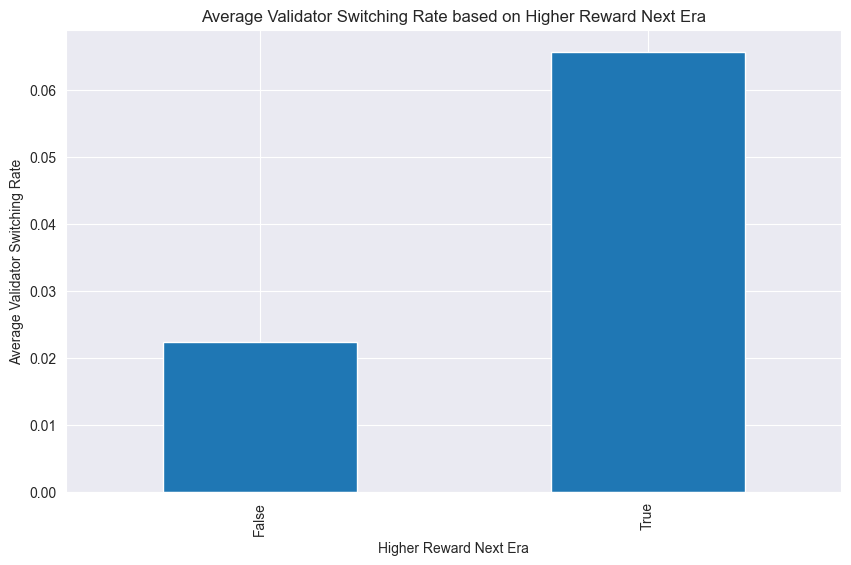

In [32]:
# Print the result
print(mean_switch_rate)

# Plot the result
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
mean_switch_rate.plot(kind='bar')
plt.title('Average Validator Switching Rate based on Higher Reward Next Era')
plt.xlabel('Higher Reward Next Era')
plt.ylabel('Average Validator Switching Rate')
plt.savefig('Average Validator Switching Rate.pdf')
plt.show()

The total number of validator switches by all nominators is: 1214
The number of nominators who have been associated with more than one validator is: 67447


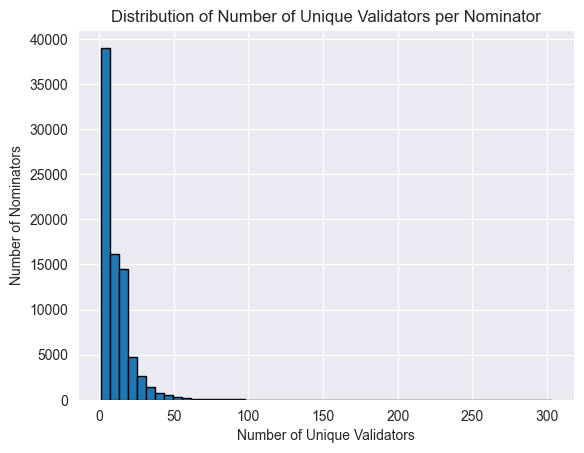

In [59]:
# Calculate the frequency of nominators switching validators
df['validator_switch'] = ((df['validator_id'] != df['validator_id'].shift(1)) & (df['nominator_id'] == df['nominator_id'].shift(1))).astype(int)
validator_switch_frequency = df['validator_switch'].sum()
print(f'The total number of validator switches by all nominators is: {validator_switch_frequency}')

# Count the number of unique validators for each nominator
unique_validators_per_nominator = df.groupby('nominator_id')['validator_id'].nunique()

# Count the number of nominators who have more than 1 validator
nominators_with_multiple_validators = unique_validators_per_nominator[unique_validators_per_nominator > 1].count()
print(f'The number of nominators who have been associated with more than one validator is: {nominators_with_multiple_validators}')

# Plot the distribution of the number of unique validators per nominator
unique_validators_per_nominator.plot(kind='hist', bins=50, edgecolor='black')
plt.title('Distribution of Number of Unique Validators per Nominator')
plt.xlabel('Number of Unique Validators')
plt.ylabel('Number of Nominators')
plt.show()

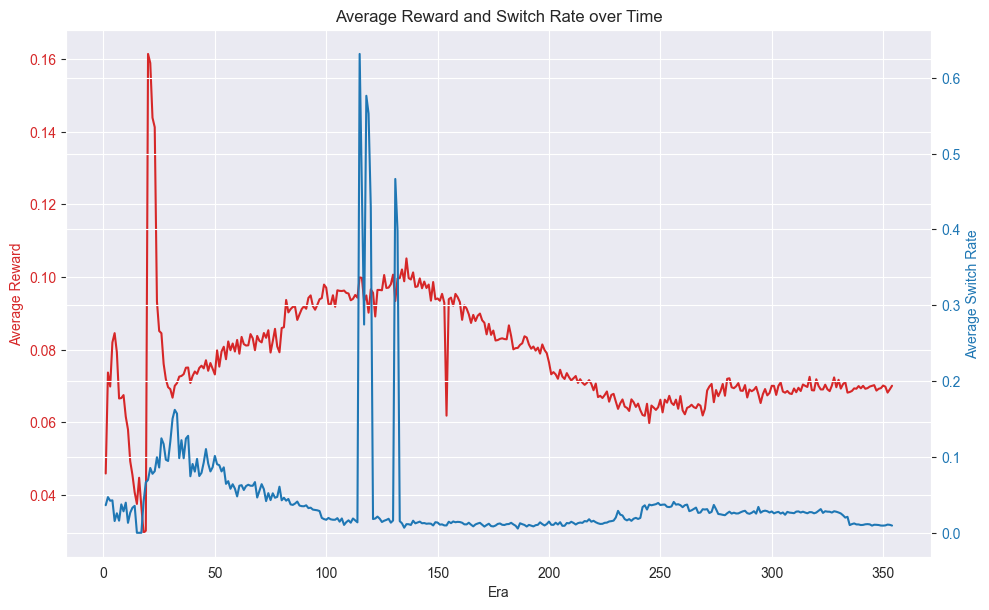

In [34]:
# Average reward and switch rate for each era
era_data = df.groupby('era').agg({'total_reward_current': 'mean', 'validator_switch': 'mean'})

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Era')
ax1.set_ylabel('Average Reward', color=color)
ax1.plot(era_data.index, era_data['total_reward_current']/10**12/365, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Switch Rate', color=color)
ax2.plot(era_data.index, era_data['validator_switch'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Average Reward and Switch Rate over Time')
plt.savefig('Average Reward and Switch Rate over Time.pdf')
plt.show()

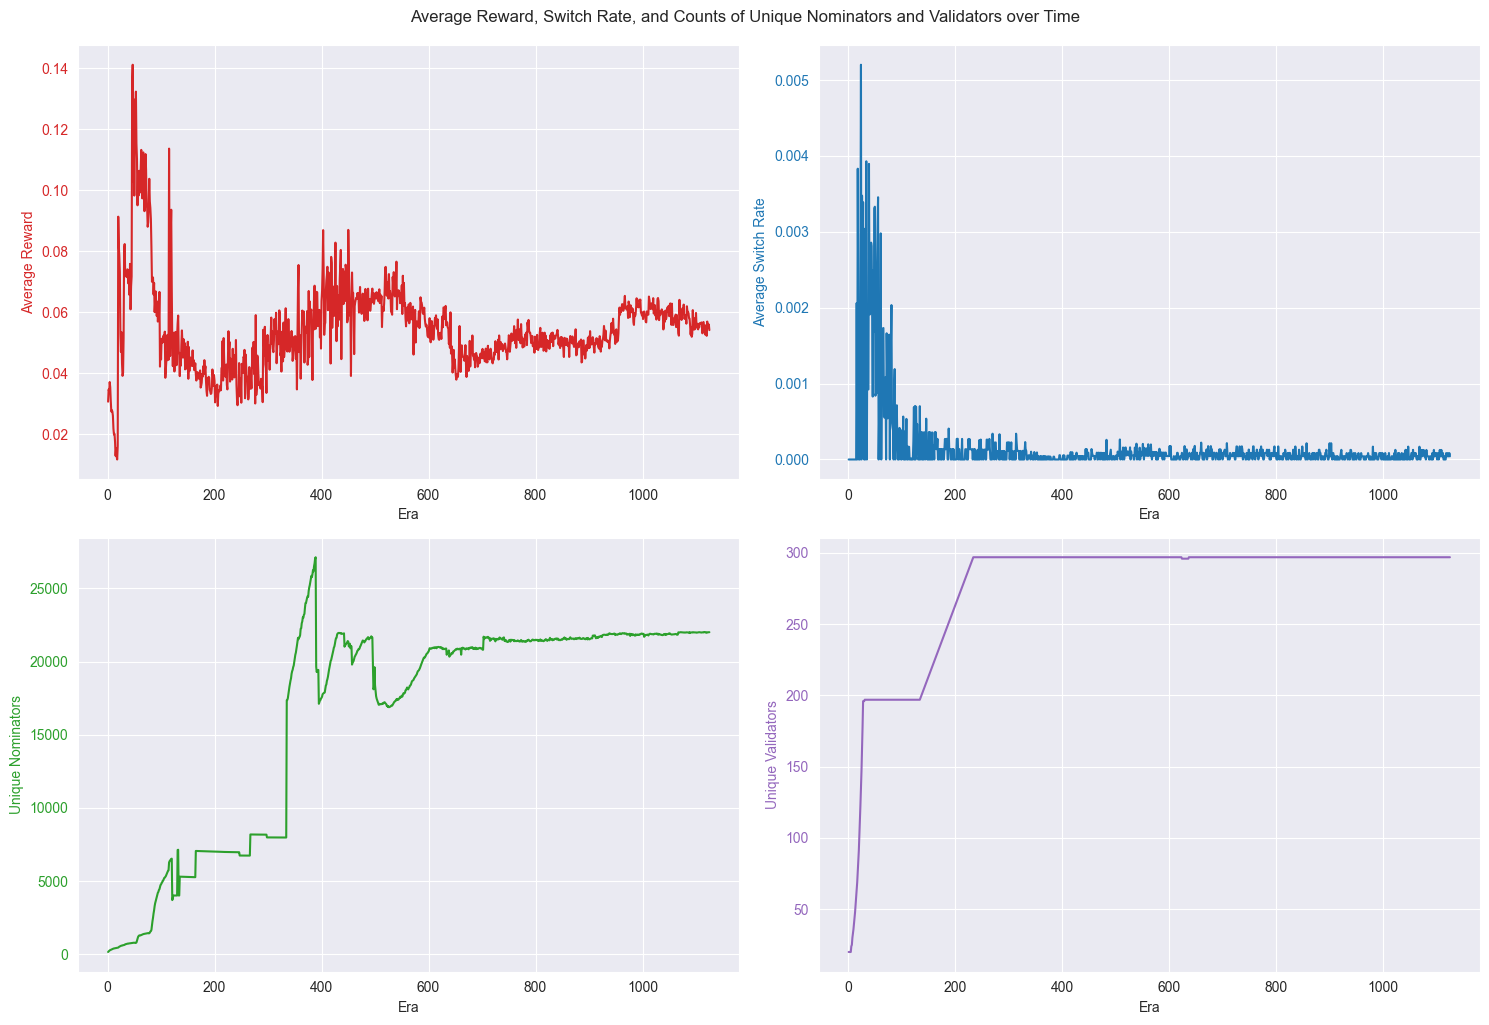

In [61]:
# Including nominator_id and validator_id in the groupby operation
era_data = df.groupby('era').agg({
    'total_reward_current': 'mean',
    'validator_switch': 'mean',
    'nominator_id': pd.Series.nunique,
    'validator_id': pd.Series.nunique})

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

color = 'tab:red'
ax1.set_xlabel('Era')
ax1.set_ylabel('Average Reward', color=color)
ax1.plot(era_data.index, era_data['total_reward_current']/10**12/365, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_xlabel('Era')
ax2.set_ylabel('Average Switch Rate', color=color)
ax2.plot(era_data.index, era_data['validator_switch'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

color = 'tab:green'
ax3.set_xlabel('Era')
ax3.set_ylabel('Unique Nominators', color=color)
ax3.plot(era_data.index, era_data['nominator_id'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

color = 'tab:purple'
ax4.set_xlabel('Era')
ax4.set_ylabel('Unique Validators', color=color)
ax4.plot(era_data.index, era_data['validator_id'], color=color)
ax4.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.suptitle('Average Reward, Switch Rate, and Counts of Unique Nominators and Validators over Time', y=1.02)
plt.show()

/var/folders/wf/5crfrw2n2bj95k071nfq9hcw0000gn/T/ipykernel_2520/2157154016.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['reward_percentage'] = df_filtered['nominator_reward'] / df_filtered['nominator_bonded']


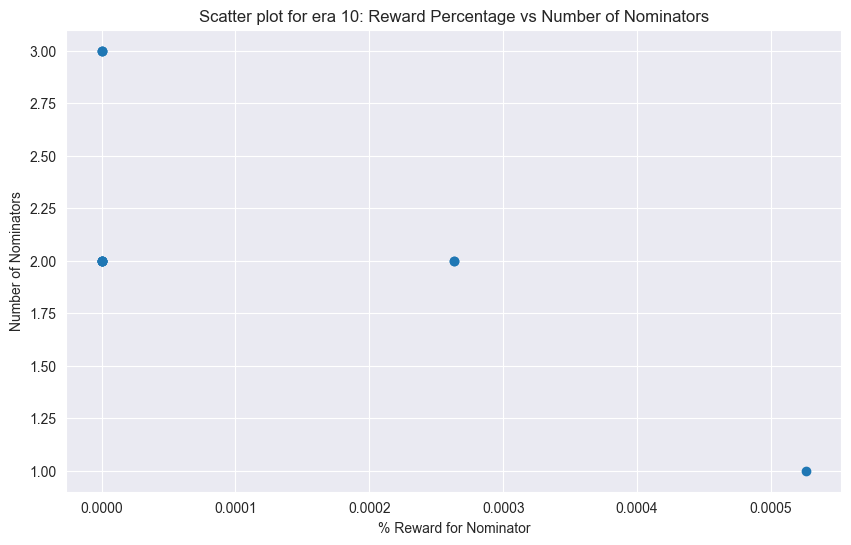

In [38]:
import matplotlib.pyplot as plt

# Filter for era 10 and nominators who switched validator
df_filtered = df[(df['era'] == 10) & (df['validator_switch'] == 1)]

# Calculate reward percentage for each nominator
df_filtered['reward_percentage'] = df_filtered['nominator_reward'] / df_filtered['nominator_bonded']

# Group by validator and count the number of nominators
validator_counts = df_filtered.groupby('validator_id').size()

# Create scatter plot
plt.figure(figsize=(10,6))
plt.scatter(df_filtered['reward_percentage']/365, validator_counts[df_filtered['validator_id']])
plt.xlabel('% Reward for Nominator')
plt.ylabel('Number of Nominators')
plt.title('Scatter plot for era 10: Reward Percentage vs Number of Nominators')
plt.show()

In [41]:
import os
import seaborn as sns
import imageio
import matplotlib.pyplot as plt

# Filter nominators who switched validator
df_switched = df[df['validator_switch'] == 1].copy()

# Calculate reward percentage for each nominator
# Handle zero 'nominator_bonded' values
df_switched.loc[df_switched['nominator_bonded'] == 0, 'nominator_bonded'] = np.nan

# Now calculate reward percentage
df_switched['reward_percentage'] = df_switched['nominator_reward'] / df_switched['nominator_bonded']


# Group by era, validator and count the number of nominators
# Group by era, validator and count the number of nominators, and calculate mean reward_percentage
df_grouped = df_switched.groupby(['era', 'validator_id']).agg({
    'reward_percentage': 'mean'
}).reset_index()

df_grouped['num_nominators'] = df_switched.groupby(['era', 'validator_id']).size().values

# Now you should be able to access 'reward_percentage' from 'df_grouped'
max_reward_percentage = df_grouped['reward_percentage'].max()

# Calculate max and min values for axes

max_num_nominators = df_grouped['num_nominators'].max()
min_reward_percentage = df_grouped['reward_percentage'].min()
min_num_nominators = df_grouped['num_nominators'].min()

# Create a directory to store the images
if not os.path.exists('images'):
    os.makedirs('images')

# Loop over each era to create the plots
for era in df_grouped['era'].unique():
    era_df = df_grouped[df_grouped['era'] == era]

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(era_df['reward_percentage'], era_df['num_nominators'])
    plt.xlabel('Reward')
    plt.ylabel('Number of Nominators')
    plt.title(f'Scatter plot for era {era}: Reward vs Number of Nominators')
    plt.xlim(min_reward_percentage, 0.001)
    plt.ylim(min_num_nominators, 10)

    plt.savefig(f'images/era_{era}.png')
    plt.close()

# Create the GIF
images = [imageio.imread(f'images/era_{era}.png') for era in df_grouped['era'].unique()]
imageio.mimsave('nominators_switches.gif', images, duration=100)

/var/folders/wf/5crfrw2n2bj95k071nfq9hcw0000gn/T/ipykernel_2520/3787664544.py:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f'images/era_{era}.png') for era in df_grouped['era'].unique()]


In [47]:
# Filter nominators who didn't switch validator
df_did_not_switch = df[df['validator_switch'] == 0].copy()

# Calculate reward percentage for each nominator
# Handle zero 'nominator_bonded' values
df_did_not_switch.loc[df_did_not_switch['nominator_bonded'] == 0, 'nominator_bonded'] = np.nan

# Now calculate reward percentage
df_did_not_switch['reward_percentage'] = df_did_not_switch['nominator_reward'] / df_did_not_switch['nominator_bonded']


# Group by era, validator and count the number of nominators, and calculate mean reward_percentage
df_grouped_did_not_switch = df_did_not_switch.groupby(['era', 'validator_id']).agg({
    'reward_percentage': 'mean'
}).reset_index()




df_grouped_did_not_switch['num_nominators'] = df_did_not_switch.groupby(['era', 'validator_id']).size().values

# Loop over each era to create the plots
for era in df_grouped['era'].unique():
    era_df_switched = df_grouped[df_grouped['era'] == era]
    era_df_did_not_switch = df_grouped_did_not_switch[df_grouped_did_not_switch['era'] == era]

    # Create a scatter plot
    plt.figure(figsize=(10, 6))

    # Scatter for switched nominators
    plt.scatter(era_df_switched['reward_percentage'], era_df_switched['num_nominators'], color='blue')

    # Scatter for non-switched nominators
    plt.scatter(era_df_did_not_switch['reward_percentage'], era_df_did_not_switch['num_nominators'], color='red')

    plt.xlabel('Reward')
    plt.ylabel('Number of Nominators')
    plt.title(f'Scatter plot for era {era}: Reward vs Number of Nominators')
    plt.xlim(min_reward_percentage, 0.01)
    plt.ylim(min_num_nominators,300)

    plt.savefig(f'images/era_{era}.png')
    plt.close()

# Create the GIF
images = [imageio.imread(f'images/era_{era}.png') for era in df_grouped['era'].unique()]
imageio.mimsave('nominators_switches_and_not.gif', images, duration=100)


/var/folders/wf/5crfrw2n2bj95k071nfq9hcw0000gn/T/ipykernel_2520/2721357246.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f'images/era_{era}.png') for era in df_grouped['era'].unique()]


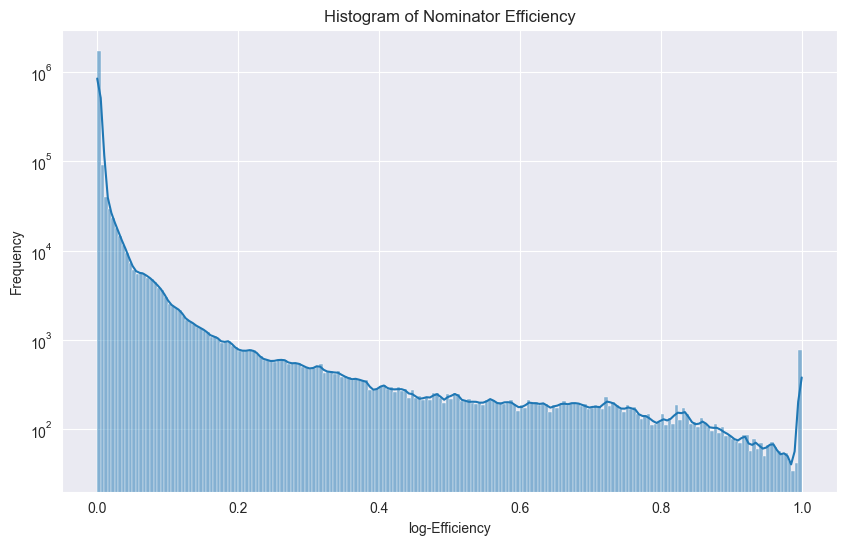

Mean Efficiency: 0.0152
Standard Deviation of Efficiency: 0.0734


In [57]:
df['max_reward'] = df.groupby('era')['nominator_reward'].transform('max')
df['efficiency'] = df['nominator_reward'] / df['max_reward']

# Summary statistics
# Convert efficiency column to float
df['efficiency'] = df['efficiency'].astype(float)

# Now you should be able to calculate mean and std
mean_efficiency = df['efficiency'].mean()
std_efficiency = df['efficiency'].std()

# Histogram
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['efficiency'], bins=200, kde=True, log = True)
plt.title('Histogram of Nominator Efficiency')
plt.xlabel('log-Efficiency')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display mean and standard deviation
print(f"Mean Efficiency: {mean_efficiency:.4f}")
print(f"Standard Deviation of Efficiency: {std_efficiency:.4f}")


Correlation between stake and reward: 0.3873


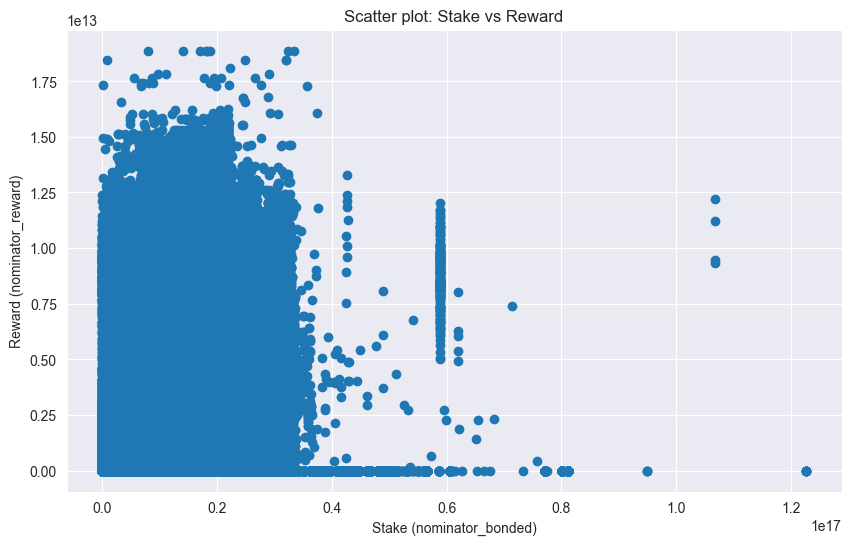

In [62]:
# Calculate the correlation between 'nominator_bonded' and 'nominator_reward'

df['nominator_bonded'] = pd.to_numeric(df['nominator_bonded'], errors='coerce')
df['nominator_reward'] = pd.to_numeric(df['nominator_reward'], errors='coerce')


correlation = df['nominator_bonded'].corr(df['nominator_reward'])
print(f"Correlation between stake and reward: {correlation:.4f}")

# Create a scatter plot of 'nominator_bonded' vs 'nominator_reward'
plt.figure(figsize=(10, 6))
plt.scatter(df['nominator_bonded'], df['nominator_reward'])
plt.xlabel('Stake (nominator_bonded)')
plt.ylabel('Reward (nominator_reward)')
plt.title('Scatter plot: Stake vs Reward')
plt.grid(True)
plt.show()

In [ ]:
# Calculate the correlation between 'nominator_bonded' and 'nominator_reward'

df['validator_bonded'] = pd.to_numeric(df['nominator_bonded'], errors='coerce')
df['_reward'] = pd.to_numeric(df['nominator_reward'], errors='coerce')


correlation = df['nominator_bonded'].corr(df['nominator_reward'])
print(f"Correlation between stake and reward: {correlation:.4f}")

# Create a scatter plot of 'nominator_bonded' vs 'nominator_reward'
plt.figure(figsize=(10, 6))
plt.scatter(df['nominator_bonded'], df['nominator_reward'])
plt.xlabel('Stake (nominator_bonded)')
plt.ylabel('Reward (nominator_reward)')
plt.title('Scatter plot: Stake vs Reward')
plt.grid(True)
plt.show()

Summary statistics for nominator rewards:
count     2108631
unique    1026236
top             0
freq        37572
Name: nominator_reward, dtype: object

Summary statistics for validator rewards:
count           2108631
unique            20970
top       8575890654132
freq                512
Name: validator_reward, dtype: object


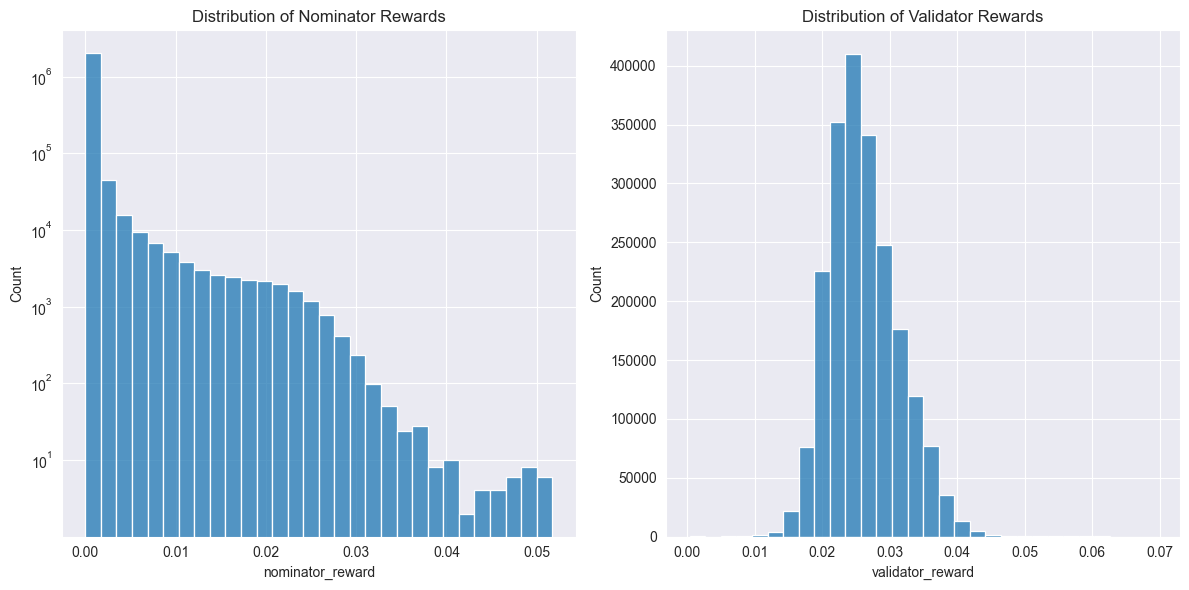

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it has columns 'nominator_reward' and 'validator_reward'

# Summary statistics
nominator_reward_summary = df['nominator_reward'].describe()
validator_reward_summary = df['validator_reward'].describe()

print("Summary statistics for nominator rewards:")
print(nominator_reward_summary)

print("\nSummary statistics for validator rewards:")
print(validator_reward_summary)

# Histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['nominator_reward']/(10**12)/365, log = True, kde=False, bins=30)
plt.title('Distribution of Nominator Rewards')

plt.subplot(1, 2, 2)
sns.histplot(df['validator_reward']/(10**12)/365, kde=False, bins=30)
plt.title('Distribution of Validator Rewards')

plt.tight_layout()
plt.savefig('Distribution of Validator Rewards 350.pdf')
plt.show()

In [43]:
# First, count the number of unique eras
total_eras = df['era'].nunique()

# Calculate the number of eras that each nominator appears in
nominator_eras = df.groupby('nominator_id')['era'].nunique()

# Filter for nominators that appear in at least 90% of the eras
active_nominators = nominator_eras[nominator_eras >= total_eras * 0.5]

# Select the first 5 nominators from the active_nominators list
selected_nominators = active_nominators.index[:]

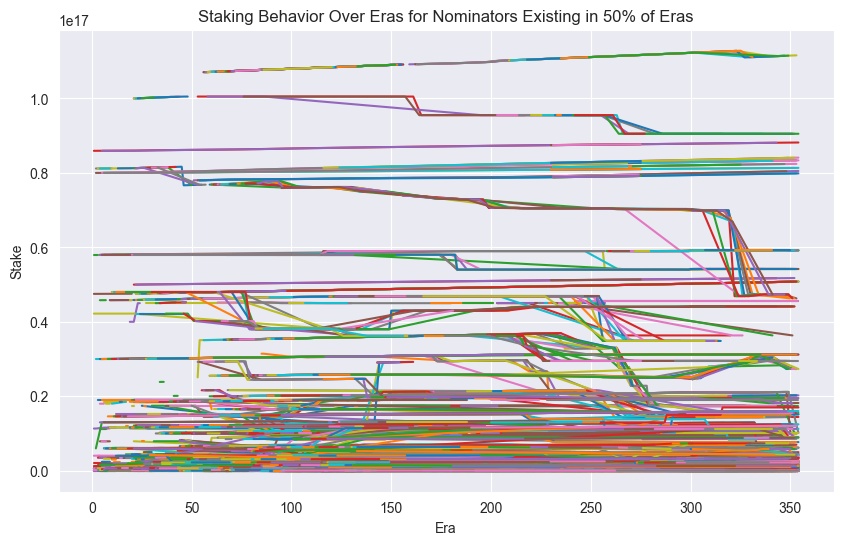

In [44]:
plt.figure(figsize=(10, 6))

for nominator in selected_nominators:
    nominator_data = df[df['nominator_id'] == nominator]
    for validator in nominator_data['validator_id'].unique():
        validator_data = nominator_data[nominator_data['validator_id'] == validator]
        plt.plot(validator_data['era'], validator_data['nominator_bonded'], label=f'Nominator {nominator} - Validator {validator}')

plt.xlabel('Era')
plt.ylabel('Stake')
plt.title('Staking Behavior Over Eras for Nominators Existing in 50% of Eras')
# plt.legend(loc='upper left')
plt.savefig('Staking Behavior Over Eras for Nominators Existing in 50% of Eras 354.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

grouped = df[df['nominator_id'].isin(selected_nominators)].groupby('nominator_id')
for nominator, nominator_data in grouped:
    for validator in nominator_data['validator_id'].unique():
        validator_data = nominator_data[nominator_data['validator_id'] == validator]
        plt.plot(validator_data['era'], validator_data['nominator_bonded'], label=f'Nominator {nominator} - Validator {validator}')

plt.xlabel('Era')
plt.ylabel('Stake')
plt.title('Staking Behavior Over Eras for Nominators Existing in 50% of Eras')
# plt.legend(loc='upper left')
plt.show()


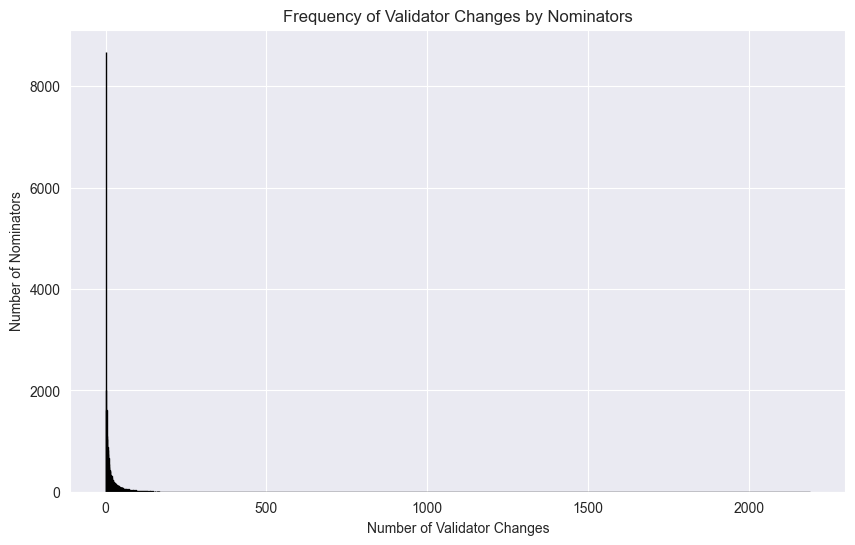

In [18]:
# Sort data by era for each nominator and create a new column that indicates when a nominator switches validators.
df = df.sort_values(by=['nominator_id', 'era'])
df['validator_change'] = df.groupby('nominator_id')['validator_id'].shift() != df['validator_id']

# Count the number of validator changes for each nominator.
validator_changes = df[df['validator_change']].groupby('nominator_id').size()

# Plot a histogram of the number of validator changes.
plt.figure(figsize=(10, 6))
plt.hist(validator_changes, bins=range(0, validator_changes.max() + 1), edgecolor='black')
plt.xlabel('Number of Validator Changes')
plt.ylabel('Number of Nominators')
plt.title('Frequency of Validator Changes by Nominators')
plt.show()

pg_dump: error: too many command-line arguments (first is "KwoZM6v60qAMXhtIxGmUC.oFCs9QQS7~")
Try "pg_dump --help" for more information.
